In [61]:
import numpy as np 
import pandas as pd 

import tqdm

import os

import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

In [62]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [63]:
use_names = ['Tram Acceleration Full', 'Tram Braking Full', 'Tram Full']

In [64]:
CLASSES = [0, 1, 2]

In [98]:
path = '/kaggle/input/separated-sounds/new sounds/'

In [101]:
pr  = 0
for folder_name in os.listdir(path):
    if folder_name in use_names:
        dataset = tf.data.Dataset.list_files(path + folder_name + '/*.wav')
        dataset = tf.data.Dataset.zip((dataset, tf.data.Dataset.from_tensor_slices \
                                       (tf.keras.utils.to_categorical \
                                        ([use_names.index(folder_name)] * len(dataset), len(CLASSES)))))
        if pr:
            data = pr.concatenate(dataset)
            pr = data
        else:
            pr = dataset

In [102]:
len(data)

1031

In [8]:
# lengths = []
# for file in os.listdir(POS):
#     tensor_wave = load_wav_16k_mono(os.path.join(POS, file))
#     lengths.append(len(tensor_wave))

In [9]:
# tf.math.reduce_mean(lengths)

In [10]:
# tf.math.reduce_min(lengths)

In [11]:
# tf.math.reduce_max(lengths)

In [13]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [14]:
def preprocess_for_predict(file_path): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    spectrogram = tf.reshape(spectrogram, (1,spectrogram.shape[0], spectrogram.shape[1], spectrogram.shape[2]))
    return spectrogram

In [116]:
path, label = data.shuffle(buffer_size=1000).as_numpy_iterator().next()
spectrogram, label = preprocess(path, label)
path, label

(b'/kaggle/input/separated-sounds/new sounds/Tram Acceleration Full/segment_177.wav',
 array([1., 0., 0.], dtype=float32))

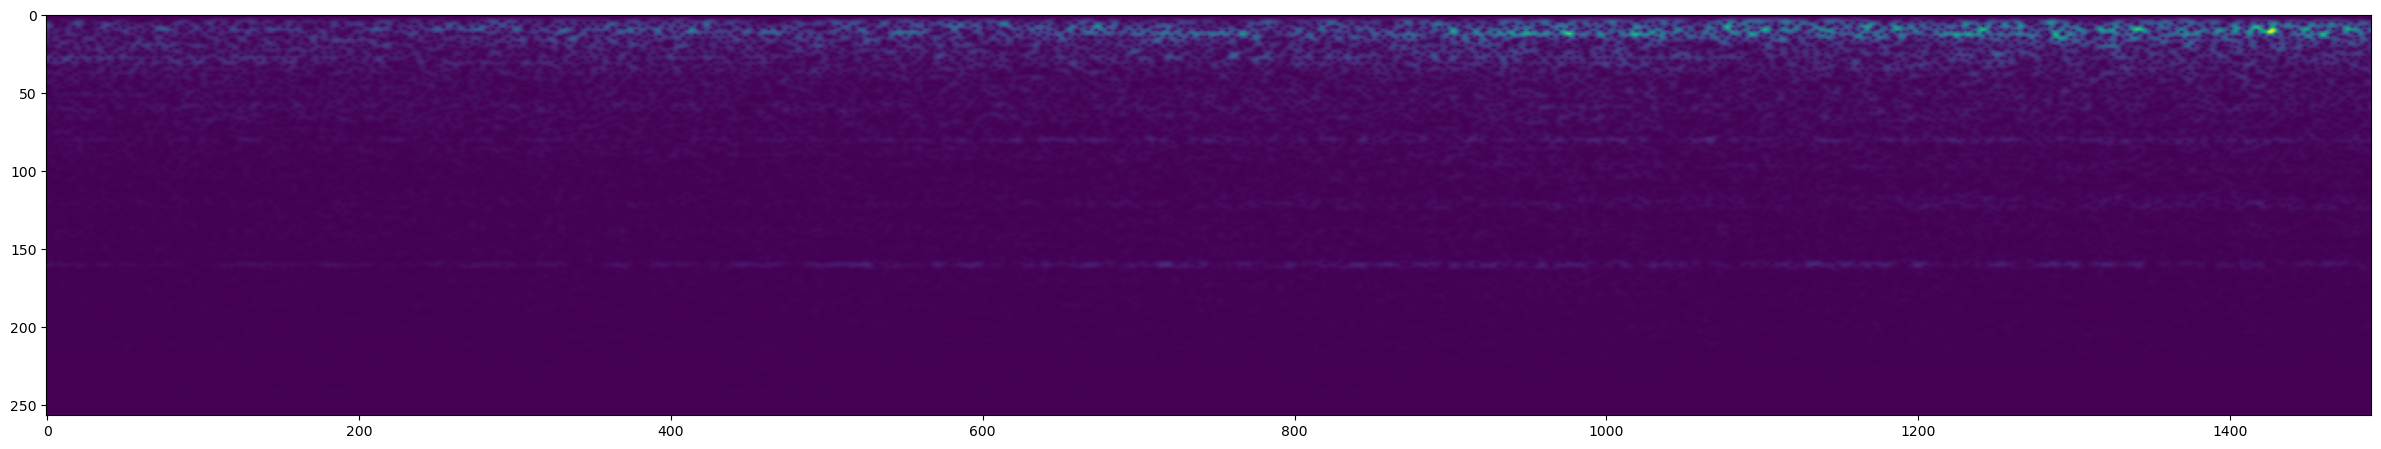

In [117]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [118]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(1)
# data = data.prefetch(8)

In [119]:
train_size = int(len(data)*.7)
test_size = len(data) - train_size
train_size, test_size

(721, 310)

In [120]:
train = data.take(train_size)
test = data.skip(train_size).take(test_size)

In [121]:
model = Sequential()
model.add(Conv2D(1, kernel_size=(3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(1, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(CLASSES), activation='sigmoid'))

In [122]:
model.compile('Adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.Recall(thresholds=0),tf.keras.metrics.Precision(thresholds=0),
                       tfa.metrics.F1Score(num_classes=len(CLASSES))])

In [123]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1489, 255, 1)      10        
                                                                 
 conv2d_3 (Conv2D)           (None, 1487, 253, 1)      10        
                                                                 
 flatten_1 (Flatten)         (None, 376211)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               48155136  
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 48,155,543
Trainable params: 48,155,543
Non-trainable params: 0
_________________________________________________________________


In [124]:
hist = model.fit(train, epochs=4)

Epoch 1/4


/opt/conda/lib/python3.7/site-packages/keras/backend.py:5677: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits, "Sigmoid", "binary_crossentropy"


721/721 [==============================] - 475s 636ms/step - loss: 0.7026 - recall_1: 1.0000 - precision_1: 0.3333 - f1_score: 0.3773
Epoch 2/4
721/721 [==============================] - 456s 633ms/step - loss: 0.3843 - recall_1: 1.0000 - precision_1: 0.3333 - f1_score: 0.7470
Epoch 3/4
721/721 [==============================] - 457s 634ms/step - loss: 0.2251 - recall_1: 1.0000 - precision_1: 0.3333 - f1_score: 0.8980
Epoch 4/4
721/721 [==============================] - 456s 632ms/step - loss: 0.0675 - recall_1: 1.0000 - precision_1: 0.3340 - f1_score: 0.9725


In [125]:
y_pred = []
y_test_all = []
for i in range(len(test)):
    X_test, y_test = test.as_numpy_iterator().next()
    yhat = model.predict(X_test)
    y_pred.append(np.argmax(yhat,axis=1)[0])
    y_test_all.append(np.argmax(y_test, axis=1)[0])

1/1 [==============================] - 0s 75ms/step


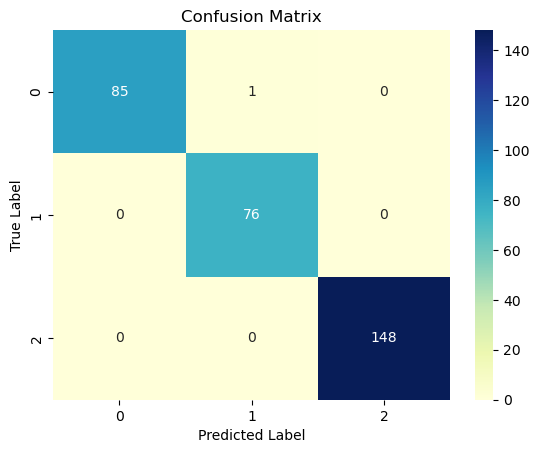

In [126]:
# Compute confusion matrix
y_true = list(y_test_all)
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt='d')
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [ ]:
model.save('new_best_model_3_11_16')

In [ ]:
#test model
# model = tf.keras.models.load_model('/kaggle/input/best-model-for-3-11-16/new_best_model_3_11_16')
# np.argmax(model.predict(preprocess_for_predict('/kaggle/input/random/AB_25.wav')), axis=1)

In [ ]:
!zip -r output.zip ./